In [2]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

#plot
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

#NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import string
import re

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!pip install -U -q PyDrive

In [5]:
#Google Colab Auth - Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
#Google Drive - List files
file_list = drive.ListFile({'q': "'1DKJEpwYEPfGzEOzZZ1TwVM_pZIc4RnbF' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: train.csv, id: 1piDuPiqjKJzF2W1g134KlnKFCaGJNId6


##Data

In [7]:
#Get data
train_downloaded = drive.CreateFile({'id': '1piDuPiqjKJzF2W1g134KlnKFCaGJNId6'})
train_downloaded.GetContentFile('train.csv')

In [8]:
import pandas as pd

#Load data to dataframe
data = pd.read_csv('train.csv')

In [9]:
data.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [9]:
#Fuction to prepare texts
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"[^a-zA-z\s]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ##remove less than 3 letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text


In [10]:
#data preparation
data=data.fillna(' ')
data['all'] = data['author'] +' '+ data['title'] +' '+ data['text']

# apply the clean_text function to data['all']
data['all'] = data['all'].map(lambda x: clean_text(x))

In [11]:
#count words in text -> data all lenght
data['all_length'] = data['all'].str.split().str.len()

In [13]:
data.head(5)

,id,title,author,text,label,all,all_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrel lucus hous aid didn even comey letter j...,424
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,daniel flynn flynn hillari clinton woman campu...,355
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnew truth might fire truth might fir...,664
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss civilian kill singl airstrik i...,281
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jail fiction unpu...,96


In [14]:
#Count words distribution
data['all_length'].describe(percentiles=[.10, .30, .35, .65, .90, .95,.97])

count    20800.000000
mean       395.444135
std        426.150847
min          0.000000
10%         62.000000
30%        174.000000
35%        199.000000
50%        297.000000
65%        434.000000
90%        755.000000
95%        967.000000
97%       1200.000000
max      10890.000000
Name: all_length, dtype: float64

## Tokenizer and Padding Words

In [12]:
# Create sequence
def create_sequence(maxlen):
  maxlen = maxlen
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data['all'])
  sequences = tokenizer.texts_to_sequences(data['all'])
  # determine the vocabulary size
  vocabulary_size = len(tokenizer.word_index) + 1
  return sequences, vocabulary_size 

def num_pad(a,b):
  return a-b

#padding with words from document (in sequence)
def padding_words(maxlen, sequences):
  count = 0
  for s in sequences:
    if len(s) == 0:
      a = np.vstack((a, np.zeros((maxlen),dtype=int)))
    else:
      if count == 0:
        if len(s) >= maxlen:
          a = np.resize(np.asarray(s),(1,maxlen))
        else:
          a = np.asarray(s)
          a = np.pad(a, (0, num_pad(maxlen,len(a))), 'wrap')
      else:
        if len(s) >= maxlen:
          b = np.resize(np.asarray(s),(1,maxlen))
          a = np.vstack((a, b))
        else:
          b = np.asarray(s)
          b = np.pad(b, (0, num_pad(maxlen,len(b))), 'wrap')
          a = np.vstack((a, b))
    count +=1
  return a  

## Models

In [13]:
##Models
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

##plot metrics
def plot_metrics(hist):
  fig = plt.figure()
  plt.subplot(211)
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc']) 
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train',
              'Test'],
              loc='lower right', prop={'size': 10})

  plt.subplot(212)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train',
              'Test'],
              loc='upper right', prop={'size': 10})
  fig.show()
  
def plot_loss(hist):
  fig = plt.figure()
  plt.plot(hist.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  fig.show()

##LSTM
def LSTM_model(maxlen):
  # Network architecture
  model = Sequential()
  model.add(Embedding(vocabulary_size, 96, input_length = maxlen))
  model.add(LSTM(128, dropout=0.35, recurrent_dropout=0.35))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # Fit the model
  hist = model.fit(X, Y, validation_split=0.25, batch_size = 500, epochs=10)
  plot_metrics(hist)
  plot_loss(hist)
  
##CNN + LSTM
# Network architecture
def CNN_LSTM_model(maxlen):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 50, input_length = maxlen))
  model.add(Dropout(0.5))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=4))
  model.add(LSTM(120, dropout=0.25, recurrent_dropout=0.25))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # Fit the model
  hist = model.fit(X, Y, validation_split=0.25, batch_size = 500, epochs=10)
  plot_metrics(hist)
  plot_loss(hist)
  
#Cross Validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

##LSTM
def LSTM_model_k(maxlen):
  # Network architecture
  cvscores = []
  for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 96, input_length = maxlen))
    model.add(LSTM(128, dropout=0.35, recurrent_dropout=0.35))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], Y[train], epochs=10, batch_size=500)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("ACC %.2f%% (std +/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  
##CNN + LSTM
# Network architecture
def CNN_LSTM_model_k(maxlen):
  cvscores = []
  for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 50, input_length = maxlen))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(120, dropout=0.25, recurrent_dropout=0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], Y[train], epochs=10, batch_size=500)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("ACC %.2f%% (std +/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  

## Experiments

### With Padding Words - Length 1200 words (97% documents < 1200 words)

In [12]:
#maxlength = 1200 (97% documents < 1200 words)
sequences, vocabulary_size = create_sequence(1200)
X = padding_words(1200, sequences)

#labels (y)
Y = np.array(data['label'].values)

In [0]:
print(vocabulary_size)

107179


In [0]:
print(Y.shape)

(20800,)


In [0]:
print(X.shape)

(20800, 1200)


In [0]:
print(X)

[[ 7409 12921    40 ...    53    40  1020]
 [ 1560  1862  1862 ... 10471  3961   136]
 [ 7196   603   157 ...   389  3100   674]
 ...
 [  559 11300  3957 ...  2544  1464   225]
 [ 2017  6665   900 ...    38   112 19494]
 [  609  8312   194 ...   243 32052    39]]


Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 105s 7ms/step - loss: 0.5792 - acc: 0.7217 - val_loss: 0.3611 - val_acc: 0.8815
Epoch 2/10
15600/15600 [==============================] - 106s 7ms/step - loss: 0.3342 - acc: 0.8957 - val_loss: 0.3346 - val_acc: 0.8937
Epoch 3/10
15600/15600 [==============================] - 107s 7ms/step - loss: 0.3032 - acc: 0.9062 - val_loss: 0.3084 - val_acc: 0.9021
Epoch 4/10
15600/15600 [==============================] - 109s 7ms/step - loss: 0.2655 - acc: 0.9162 - val_loss: 0.3604 - val_acc: 0.8919
Epoch 5/10
15600/15600 [==============================] - 109s 7ms/step - loss: 0.2368 - acc: 0.9224 - val_loss: 0.2428 - val_acc: 0.9252
Epoch 6/10
15600/15600 [==============================] - 109s 7ms/step - loss: 0.1767 - acc: 0.9408 - val_loss: 0.3089 - val_acc: 0.9229
Epoch 7/10
 1000/15600 [>.............................] - ETA: 1:30 - loss: 0.1486 - acc: 0.954015600/15600 [==============

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



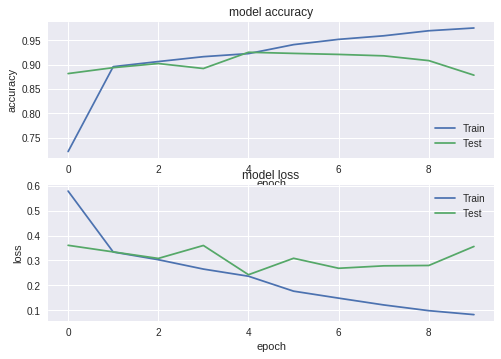

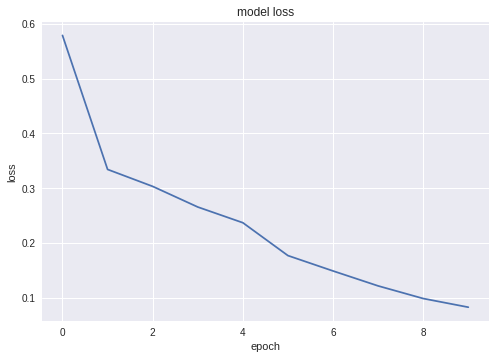

In [0]:
LSTM_model(1200)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 32s 2ms/step - loss: 0.6674 - acc: 0.5850 - val_loss: 0.5016 - val_acc: 0.8456
Epoch 2/10
15600/15600 [==============================] - 30s 2ms/step - loss: 0.4361 - acc: 0.8461 - val_loss: 0.3367 - val_acc: 0.8806
Epoch 3/10
15600/15600 [==============================] - 30s 2ms/step - loss: 0.2950 - acc: 0.9054 - val_loss: 0.2628 - val_acc: 0.9150
Epoch 4/10
15600/15600 [==============================] - 30s 2ms/step - loss: 0.2425 - acc: 0.9237 - val_loss: 0.2566 - val_acc: 0.9288
Epoch 5/10
15600/15600 [==============================] - 30s 2ms/step - loss: 0.2080 - acc: 0.9378 - val_loss: 0.2213 - val_acc: 0.9269
Epoch 6/10
15600/15600 [==============================] - 30s 2ms/step - loss: 0.1542 - acc: 0.9543 - val_loss: 0.1920 - val_acc: 0.9427
Epoch 7/10
 1500/15600 [=>............................] - ETA: 24s - loss: 0.1365 - acc: 0.962715600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



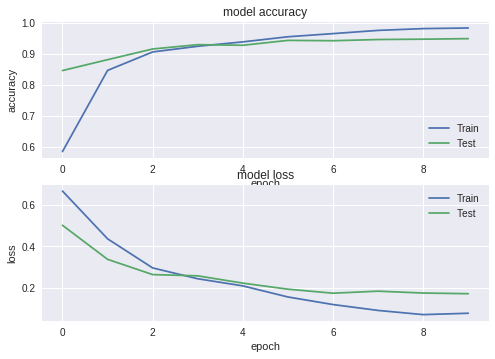

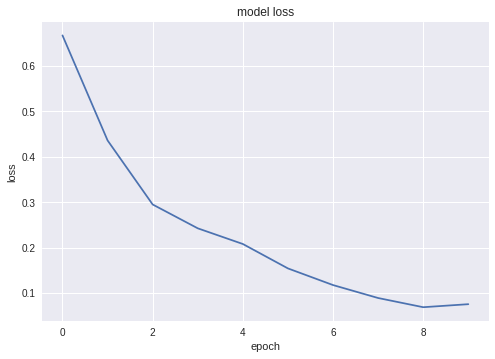

In [0]:
CNN_LSTM_model(1200)

In [15]:
LSTM_model_k(1200)

Epoch 1/10
16639/16639 [==============================] - 122s 7ms/step - loss: 0.5606 - acc: 0.7070
Epoch 2/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.3443 - acc: 0.8911
Epoch 3/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.3258 - acc: 0.8949
Epoch 4/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.2783 - acc: 0.9086
Epoch 5/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.2382 - acc: 0.9192
Epoch 6/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.1733 - acc: 0.9439
Epoch 7/10
16639/16639 [==============================] - 121s 7ms/step - loss: 0.1371 - acc: 0.9550
Epoch 8/10
 1000/16639 [>.............................] - ETA: 1:51 - loss: 0.1093 - acc: 0.968016639/16639 [==============================] - 120s 7ms/step - loss: 0.1136 - acc: 0.9641
Epoch 9/10
16639/16639 [==============================] - 120s 7ms/step - loss: 0.1116 - acc: 0.9599
Epoch 

In [14]:
CNN_LSTM_model_k(1200)

Epoch 1/10
16639/16639 [==============================] - 33s 2ms/step - loss: 0.6696 - acc: 0.5736
Epoch 2/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.4369 - acc: 0.8365
Epoch 3/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.2381 - acc: 0.9241
Epoch 4/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.2042 - acc: 0.9431
Epoch 5/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.1623 - acc: 0.9539
Epoch 6/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.2096 - acc: 0.9393
Epoch 7/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.1276 - acc: 0.9618
Epoch 8/10
 1500/16639 [=>............................] - ETA: 27s - loss: 0.1032 - acc: 0.970016639/16639 [==============================] - 31s 2ms/step - loss: 0.1081 - acc: 0.9701
Epoch 9/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.0903 - acc: 0.9735
Epoch 10/10
1663

### With Padding Words - Length 800 words (90% documents < 800 words)

In [16]:
#maxlength = 800 (90% documents < 800 words)
sequences, vocabulary_size = create_sequence(800)
X = padding_words(800, sequences)

#labels (y)
Y = np.array(data['label'].values)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 79s 5ms/step - loss: 0.5861 - acc: 0.6967 - val_loss: 0.3552 - val_acc: 0.8829
Epoch 2/10
15600/15600 [==============================] - 75s 5ms/step - loss: 0.3471 - acc: 0.8797 - val_loss: 0.3389 - val_acc: 0.8821
Epoch 3/10
15600/15600 [==============================] - 75s 5ms/step - loss: 0.2875 - acc: 0.9060 - val_loss: 0.3105 - val_acc: 0.9006
Epoch 4/10
15600/15600 [==============================] - 74s 5ms/step - loss: 0.2504 - acc: 0.9179 - val_loss: 0.3068 - val_acc: 0.9031
Epoch 5/10
15600/15600 [==============================] - 75s 5ms/step - loss: 0.2062 - acc: 0.9321 - val_loss: 0.2785 - val_acc: 0.9156
Epoch 6/10
15600/15600 [==============================] - 74s 5ms/step - loss: 0.1588 - acc: 0.9461 - val_loss: 0.2841 - val_acc: 0.9150
Epoch 7/10
 1500/15600 [=>............................] - ETA: 1:00 - loss: 0.1189 - acc: 0.964015600/15600 [====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



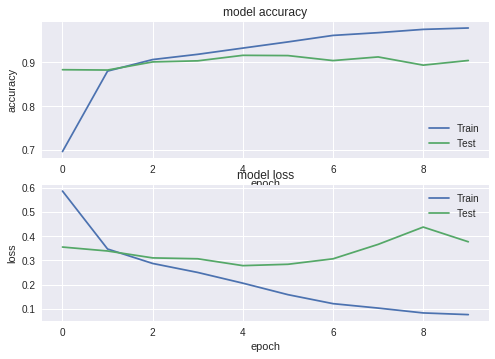

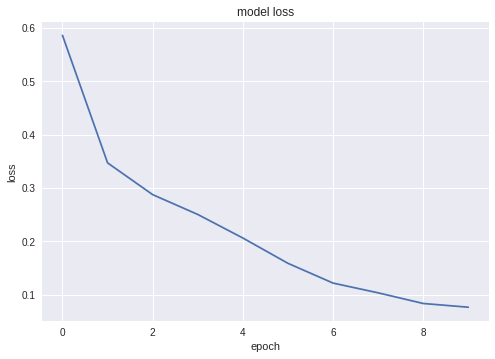

In [0]:
LSTM_model(800)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 25s 2ms/step - loss: 0.6783 - acc: 0.5674 - val_loss: 0.5862 - val_acc: 0.8644
Epoch 2/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.4408 - acc: 0.8321 - val_loss: 0.2873 - val_acc: 0.9037
Epoch 3/10
15600/15600 [==============================] - 20s 1ms/step - loss: 0.2822 - acc: 0.9113 - val_loss: 0.2649 - val_acc: 0.9192
Epoch 4/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.2530 - acc: 0.9204 - val_loss: 0.2524 - val_acc: 0.9167
Epoch 5/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.2213 - acc: 0.9390 - val_loss: 0.2353 - val_acc: 0.9333
Epoch 6/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.2714 - acc: 0.9152 - val_loss: 0.3480 - val_acc: 0.8477
Epoch 7/10
 1500/15600 [=>............................] - ETA: 16s - loss: 0.2970 - acc: 0.873315600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



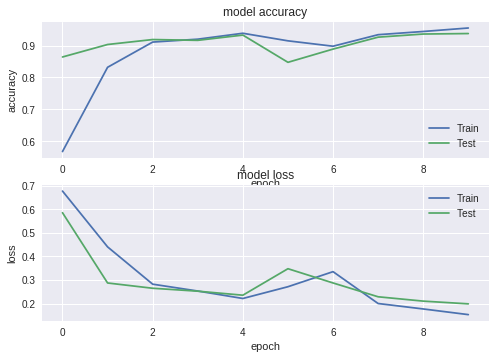

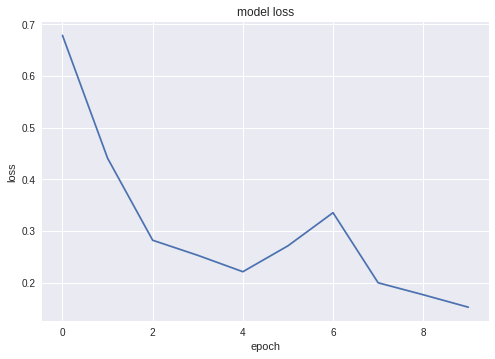

In [0]:
CNN_LSTM_model(800)

In [17]:
LSTM_model_k(800)

Epoch 1/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.5789 - acc: 0.7180
Epoch 2/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.3497 - acc: 0.8894
Epoch 3/10
16639/16639 [==============================] - 81s 5ms/step - loss: 0.3073 - acc: 0.9041
Epoch 4/10
16639/16639 [==============================] - 81s 5ms/step - loss: 0.2714 - acc: 0.9127
Epoch 5/10
16639/16639 [==============================] - 82s 5ms/step - loss: 0.2297 - acc: 0.9254
Epoch 6/10
16639/16639 [==============================] - 81s 5ms/step - loss: 0.1866 - acc: 0.9376
Epoch 7/10
16639/16639 [==============================] - 81s 5ms/step - loss: 0.1514 - acc: 0.9516
Epoch 8/10
 1500/16639 [=>............................] - ETA: 1:11 - loss: 0.1289 - acc: 0.954716639/16639 [==============================] - 81s 5ms/step - loss: 0.1277 - acc: 0.9578
Epoch 9/10
16639/16639 [==============================] - 81s 5ms/step - loss: 0.0966 - acc: 0.9681
Epoch 10/10
166

In [18]:
CNN_LSTM_model_k(800)

Epoch 1/10
16639/16639 [==============================] - 25s 2ms/step - loss: 0.6670 - acc: 0.5942
Epoch 2/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.4383 - acc: 0.8398
Epoch 3/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.3194 - acc: 0.8945
Epoch 4/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2960 - acc: 0.8982
Epoch 5/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2535 - acc: 0.9206
Epoch 6/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2197 - acc: 0.9305
Epoch 7/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.1750 - acc: 0.9464
Epoch 8/10
 1500/16639 [=>............................] - ETA: 19s - loss: 0.1674 - acc: 0.946716639/16639 [==============================] - 22s 1ms/step - loss: 0.1554 - acc: 0.9546
Epoch 9/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.1264 - acc: 0.9642
Epoch 10/10
1663

### With Padding Words - Length 400 words (60% documents < 400 words)

In [19]:
#maxlength = 400 (60% documents < 400 words)
sequences, vocabulary_size = create_sequence(400)
X = padding_words(400, sequences)

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 42s 3ms/step - loss: 0.5935 - acc: 0.6608 - val_loss: 0.3685 - val_acc: 0.8763
Epoch 2/10
15600/15600 [==============================] - 38s 2ms/step - loss: 0.3733 - acc: 0.8762 - val_loss: 0.3775 - val_acc: 0.8710
Epoch 3/10
15600/15600 [==============================] - 38s 2ms/step - loss: 0.3563 - acc: 0.8826 - val_loss: 0.3706 - val_acc: 0.8737
Epoch 4/10
15600/15600 [==============================] - 38s 2ms/step - loss: 0.3310 - acc: 0.8903 - val_loss: 0.3401 - val_acc: 0.8773
Epoch 5/10
15600/15600 [==============================] - 38s 2ms/step - loss: 0.2756 - acc: 0.9082 - val_loss: 0.2899 - val_acc: 0.9065
Epoch 6/10
15600/15600 [==============================] - 38s 2ms/step - loss: 0.2222 - acc: 0.9266 - val_loss: 0.2750 - val_acc: 0.9117
Epoch 7/10
 1500/15600 [=>............................] - ETA: 30s - loss: 0.1964 - acc: 0.932015600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



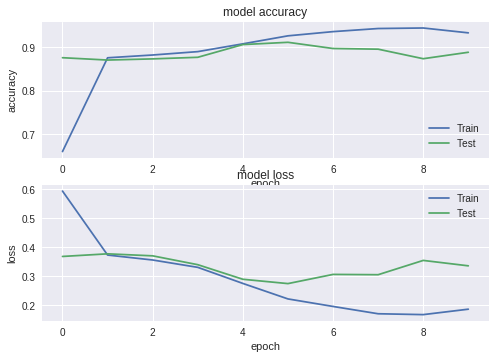

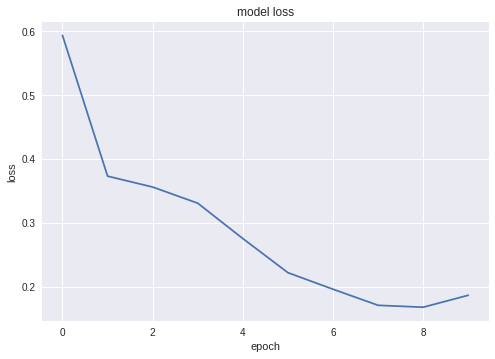

In [0]:
LSTM_model(400)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 15s 974us/step - loss: 0.6675 - acc: 0.5794 - val_loss: 0.3610 - val_acc: 0.8702
Epoch 2/10
15600/15600 [==============================] - 10s 667us/step - loss: 0.3653 - acc: 0.8696 - val_loss: 0.2673 - val_acc: 0.9181
Epoch 3/10
15600/15600 [==============================] - 10s 670us/step - loss: 0.2867 - acc: 0.9008 - val_loss: 0.3708 - val_acc: 0.9088
Epoch 4/10
15600/15600 [==============================] - 10s 667us/step - loss: 0.2436 - acc: 0.9376 - val_loss: 0.2605 - val_acc: 0.9194
Epoch 5/10
15600/15600 [==============================] - 11s 675us/step - loss: 0.2387 - acc: 0.9285 - val_loss: 0.2639 - val_acc: 0.9169
Epoch 6/10
15600/15600 [==============================] - 11s 674us/step - loss: 0.2251 - acc: 0.9315 - val_loss: 0.2604 - val_acc: 0.9173
Epoch 7/10
 1000/15600 [>.............................] - ETA: 9s - loss: 0.2310 - acc: 0.932015600/15600 [==========

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



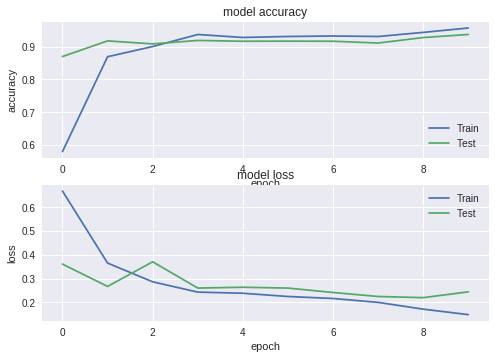

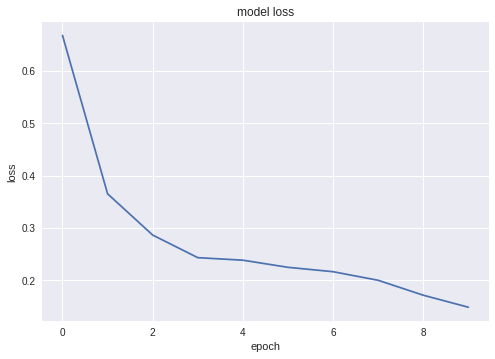

In [0]:
CNN_LSTM_model(400)

In [20]:
LSTM_model_k(400)

Epoch 1/10
16639/16639 [==============================] - 42s 3ms/step - loss: 0.5861 - acc: 0.7015
Epoch 2/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.3914 - acc: 0.8692
Epoch 3/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.3667 - acc: 0.8760
Epoch 4/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.3282 - acc: 0.8859
Epoch 5/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.2485 - acc: 0.9124
Epoch 6/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.1940 - acc: 0.9321
Epoch 7/10
16639/16639 [==============================] - 40s 2ms/step - loss: 0.1660 - acc: 0.9428
Epoch 8/10
 1500/16639 [=>............................] - ETA: 36s - loss: 0.1254 - acc: 0.955316639/16639 [==============================] - 40s 2ms/step - loss: 0.1329 - acc: 0.9526
Epoch 9/10
16639/16639 [==============================] - 41s 2ms/step - loss: 0.1213 - acc: 0.9617
Epoch 10/10
1663

In [20]:
CNN_LSTM_model_k(400)

Epoch 1/10
16639/16639 [==============================] - 15s 929us/step - loss: 0.6424 - acc: 0.6131
Epoch 2/10
16639/16639 [==============================] - 12s 697us/step - loss: 0.3453 - acc: 0.8817
Epoch 3/10
16639/16639 [==============================] - 12s 702us/step - loss: 0.2453 - acc: 0.9270
Epoch 4/10
16639/16639 [==============================] - 12s 703us/step - loss: 0.2097 - acc: 0.9424
Epoch 5/10
16639/16639 [==============================] - 12s 697us/step - loss: 0.1809 - acc: 0.9526
Epoch 6/10
16639/16639 [==============================] - 12s 701us/step - loss: 0.2075 - acc: 0.9428
Epoch 7/10
16639/16639 [==============================] - 12s 703us/step - loss: 0.1382 - acc: 0.9661
Epoch 8/10
 1000/16639 [>.............................] - ETA: 11s - loss: 0.1348 - acc: 0.967016639/16639 [==============================] - 11s 685us/step - loss: 0.1667 - acc: 0.9528
Epoch 9/10
16639/16639 [==============================] - 12s 696us/step - loss: 0.3165 - acc: 0.857

###With Padding Words - Length 297 words (50% documents < 297 words)

In [21]:
#maxlength = 297 (50% documents < 297 words)
sequences, vocabulary_size = create_sequence(297)
X = padding_words(297, sequences)

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 29s 2ms/step - loss: 0.5738 - acc: 0.7149 - val_loss: 0.3419 - val_acc: 0.9015
Epoch 2/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3650 - acc: 0.8833 - val_loss: 0.3582 - val_acc: 0.8813
Epoch 3/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3525 - acc: 0.8826 - val_loss: 0.3434 - val_acc: 0.8875
Epoch 4/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3401 - acc: 0.8871 - val_loss: 0.3345 - val_acc: 0.8912
Epoch 5/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3164 - acc: 0.8922 - val_loss: 0.3125 - val_acc: 0.8946
Epoch 6/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.2693 - acc: 0.9058 - val_loss: 0.2870 - val_acc: 0.9044
Epoch 7/10
 1500/15600 [=>............................] - ETA: 22s - loss: 0.2181 - acc: 0.925315600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



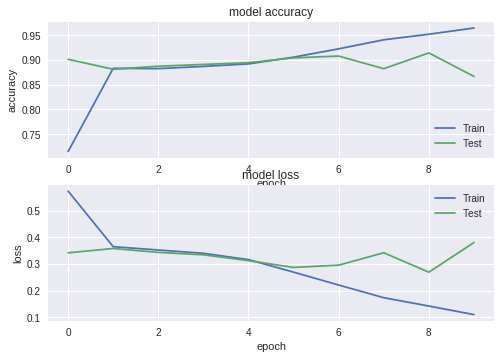

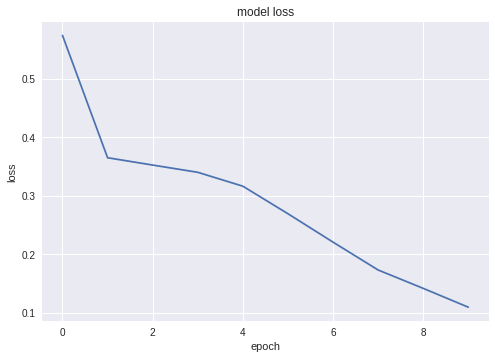

In [0]:
LSTM_model(297)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 9s 596us/step - loss: 0.6644 - acc: 0.5753 - val_loss: 0.3977 - val_acc: 0.8373
Epoch 2/10
15600/15600 [==============================] - 8s 504us/step - loss: 0.3448 - acc: 0.8788 - val_loss: 0.2795 - val_acc: 0.9133
Epoch 3/10
15600/15600 [==============================] - 8s 502us/step - loss: 0.2087 - acc: 0.9444 - val_loss: 0.2748 - val_acc: 0.9256
Epoch 4/10
15600/15600 [==============================] - 8s 499us/step - loss: 0.1890 - acc: 0.9521 - val_loss: 0.2159 - val_acc: 0.9450
Epoch 5/10
15600/15600 [==============================] - 8s 503us/step - loss: 0.1810 - acc: 0.9543 - val_loss: 0.2308 - val_acc: 0.9421
Epoch 6/10
15600/15600 [==============================] - 8s 498us/step - loss: 0.1801 - acc: 0.9549 - val_loss: 0.2313 - val_acc: 0.9350
Epoch 7/10
 1000/15600 [>.............................] - ETA: 6s - loss: 0.2260 - acc: 0.938015600/15600 [================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



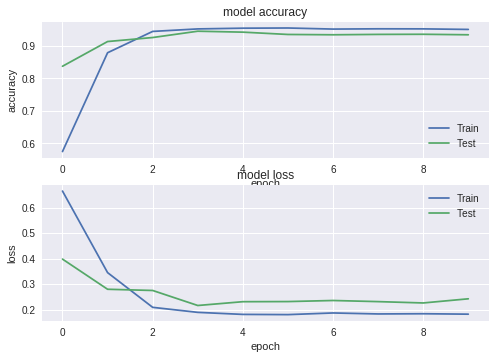

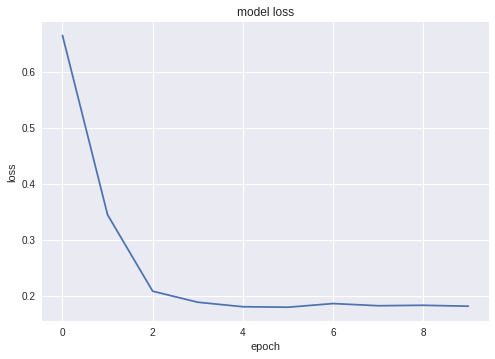

In [0]:
CNN_LSTM_model(297)

In [22]:
LSTM_model_k(297)

Epoch 1/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.5861 - acc: 0.6883
Epoch 2/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.3595 - acc: 0.8817
Epoch 3/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.3554 - acc: 0.8759
Epoch 4/10
16639/16639 [==============================] - 32s 2ms/step - loss: 0.3028 - acc: 0.8958
Epoch 5/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.2580 - acc: 0.9145
Epoch 6/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.2034 - acc: 0.9299
Epoch 7/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.1857 - acc: 0.9358
Epoch 8/10
 1500/16639 [=>............................] - ETA: 27s - loss: 0.1572 - acc: 0.944716639/16639 [==============================] - 31s 2ms/step - loss: 0.1479 - acc: 0.9519
Epoch 9/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.1233 - acc: 0.9593
Epoch 10/10
1663

In [22]:
CNN_LSTM_model_k(297)

Epoch 1/10
16639/16639 [==============================] - 13s 800us/step - loss: 0.6878 - acc: 0.5487
Epoch 2/10
16639/16639 [==============================] - 9s 519us/step - loss: 0.3634 - acc: 0.8699
Epoch 3/10
16639/16639 [==============================] - 9s 523us/step - loss: 0.2885 - acc: 0.8983
Epoch 4/10
16639/16639 [==============================] - 9s 515us/step - loss: 0.2382 - acc: 0.9300
Epoch 5/10
16639/16639 [==============================] - 9s 515us/step - loss: 0.2591 - acc: 0.9167
Epoch 6/10
16639/16639 [==============================] - 9s 517us/step - loss: 0.2547 - acc: 0.9227
Epoch 7/10
16639/16639 [==============================] - 9s 517us/step - loss: 0.2077 - acc: 0.9443
Epoch 8/10
 1000/16639 [>.............................] - ETA: 7s - loss: 0.2072 - acc: 0.947016639/16639 [==============================] - 9s 522us/step - loss: 0.2296 - acc: 0.9386
Epoch 9/10
16639/16639 [==============================] - 9s 516us/step - loss: 0.2005 - acc: 0.9463
Epoch 1

### With Padding Words - Length 200 words (35% documents < 200 words)

In [23]:
#maxlength = 200 (35% documents < 200 words)
sequences, vocabulary_size = create_sequence(200)
X = padding_words(200, sequences)

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 23s 1ms/step - loss: 0.6042 - acc: 0.6781 - val_loss: 0.3829 - val_acc: 0.8835
Epoch 2/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3683 - acc: 0.8821 - val_loss: 0.3568 - val_acc: 0.8846
Epoch 3/10
15600/15600 [==============================] - 20s 1ms/step - loss: 0.3564 - acc: 0.8843 - val_loss: 0.3544 - val_acc: 0.8848
Epoch 4/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3504 - acc: 0.8851 - val_loss: 0.3984 - val_acc: 0.8642
Epoch 5/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.4191 - acc: 0.8190 - val_loss: 0.4081 - val_acc: 0.8015
Epoch 6/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3405 - acc: 0.8613 - val_loss: 0.3087 - val_acc: 0.8900
Epoch 7/10
 1500/15600 [=>............................] - ETA: 15s - loss: 0.2693 - acc: 0.910015600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



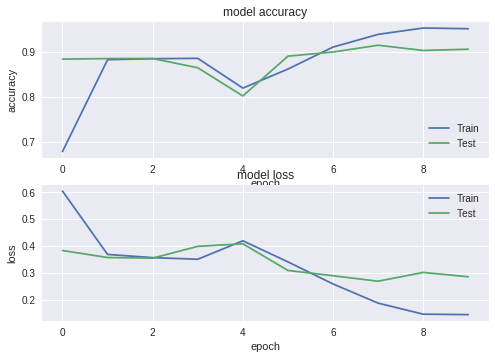

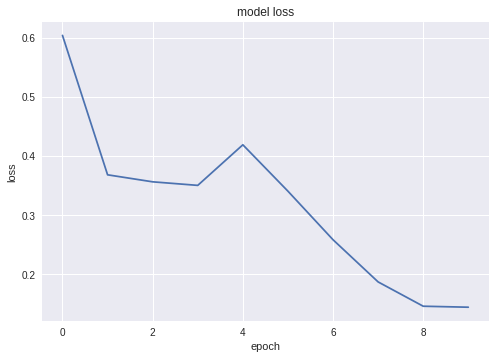

In [0]:
LSTM_model(200)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 9s 596us/step - loss: 0.6702 - acc: 0.5811 - val_loss: 0.3270 - val_acc: 0.8667
Epoch 2/10
15600/15600 [==============================] - 5s 349us/step - loss: 0.3423 - acc: 0.8706 - val_loss: 0.2254 - val_acc: 0.9213
Epoch 3/10
15600/15600 [==============================] - 5s 349us/step - loss: 0.1700 - acc: 0.9513 - val_loss: 0.1616 - val_acc: 0.9521
Epoch 4/10
15600/15600 [==============================] - 5s 349us/step - loss: 0.1111 - acc: 0.9703 - val_loss: 0.1706 - val_acc: 0.9508
Epoch 5/10
15600/15600 [==============================] - 5s 350us/step - loss: 0.0778 - acc: 0.9806 - val_loss: 0.1435 - val_acc: 0.9587
Epoch 6/10
15600/15600 [==============================] - 6s 354us/step - loss: 0.0680 - acc: 0.9821 - val_loss: 0.1497 - val_acc: 0.9590
Epoch 7/10
 3000/15600 [====>.........................] - ETA: 4s - loss: 0.0569 - acc: 0.986715600/15600 [================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



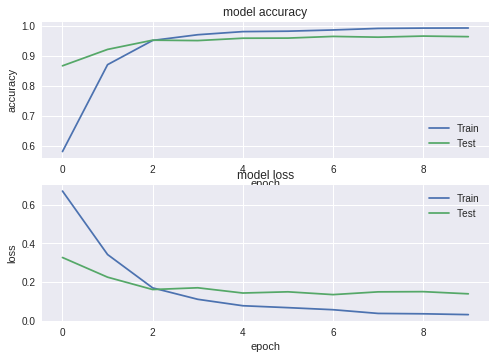

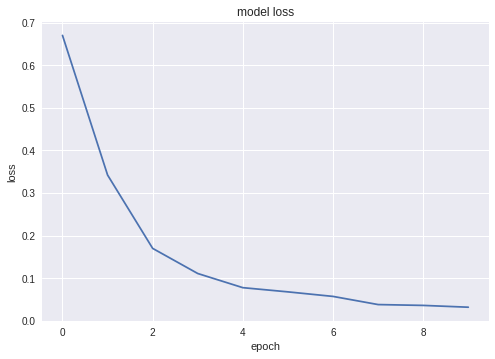

In [0]:
CNN_LSTM_model(200)

In [24]:
LSTM_model_k(200)

Epoch 1/10
16639/16639 [==============================] - 25s 1ms/step - loss: 0.5735 - acc: 0.6961
Epoch 2/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.3602 - acc: 0.8692
Epoch 3/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.3352 - acc: 0.8829
Epoch 4/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.3154 - acc: 0.8890
Epoch 5/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2838 - acc: 0.9053
Epoch 6/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2649 - acc: 0.9147
Epoch 7/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.2154 - acc: 0.9317
Epoch 8/10
 1500/16639 [=>............................] - ETA: 19s - loss: 0.2039 - acc: 0.942016639/16639 [==============================] - 22s 1ms/step - loss: 0.2099 - acc: 0.9358
Epoch 9/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.1866 - acc: 0.9407
Epoch 10/10
1663

In [24]:
CNN_LSTM_model_k(200)

Epoch 1/10
16639/16639 [==============================] - 12s 729us/step - loss: 0.6754 - acc: 0.5598
Epoch 2/10
16639/16639 [==============================] - 6s 363us/step - loss: 0.3358 - acc: 0.8746
Epoch 3/10
16639/16639 [==============================] - 6s 365us/step - loss: 0.1745 - acc: 0.9516
Epoch 4/10
16639/16639 [==============================] - 6s 363us/step - loss: 0.1123 - acc: 0.9707
Epoch 5/10
16639/16639 [==============================] - 6s 362us/step - loss: 0.0839 - acc: 0.9810
Epoch 6/10
16639/16639 [==============================] - 6s 365us/step - loss: 0.0686 - acc: 0.9836
Epoch 7/10
16639/16639 [==============================] - 6s 366us/step - loss: 0.0527 - acc: 0.9873
Epoch 8/10
 1500/16639 [=>............................] - ETA: 5s - loss: 0.0452 - acc: 0.992716639/16639 [==============================] - 6s 366us/step - loss: 0.0409 - acc: 0.9910
Epoch 9/10
16639/16639 [==============================] - 6s 367us/step - loss: 0.0382 - acc: 0.9918
Epoch 1

### With Padding 0 - Length 1200 words (97% documents < 1200 words)

In [25]:
##Padding 0
#maxlength = 1200 (97% documents < 1200 words)
sequences, vocabulary_size = create_sequence(1200)
X = pad_sequences(sequences, maxlen=1200, padding='post', truncating='post')

#labels (y)
Y = np.array(data['label'].values) 

print(X)

[[ 7409 12921    40 ...     0     0     0]
 [ 1560  1862  1862 ...     0     0     0]
 [ 7196   603   157 ...     0     0     0]
 ...
 [  559 11300  3957 ...     0     0     0]
 [ 2017  6665   900 ...     0     0     0]
 [  609  8312   194 ...     0     0     0]]


Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 139s 9ms/step - loss: 0.6937 - acc: 0.4993 - val_loss: 0.6933 - val_acc: 0.5046
Epoch 2/10
15600/15600 [==============================] - 133s 9ms/step - loss: 0.6932 - acc: 0.5051 - val_loss: 0.6931 - val_acc: 0.5004
Epoch 3/10
15600/15600 [==============================] - 133s 9ms/step - loss: 0.6928 - acc: 0.5008 - val_loss: 0.6929 - val_acc: 0.4996
Epoch 4/10
15600/15600 [==============================] - 133s 9ms/step - loss: 0.6915 - acc: 0.5196 - val_loss: 0.6924 - val_acc: 0.5044
Epoch 5/10
15600/15600 [==============================] - 133s 9ms/step - loss: 0.6904 - acc: 0.5169 - val_loss: 0.6916 - val_acc: 0.5008
Epoch 6/10
15600/15600 [==============================] - 133s 9ms/step - loss: 0.6841 - acc: 0.5117 - val_loss: 0.6912 - val_acc: 0.5013
Epoch 7/10
 1000/15600 [>.............................] - ETA: 1:54 - loss: 0.6844 - acc: 0.504015600/15600 [==============

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



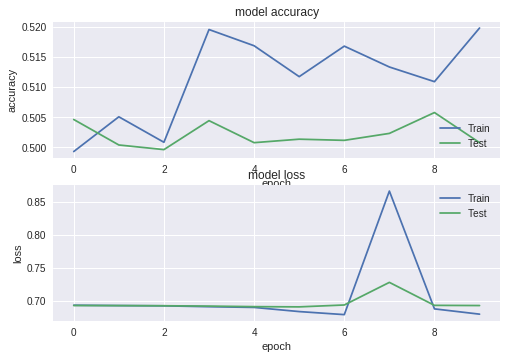

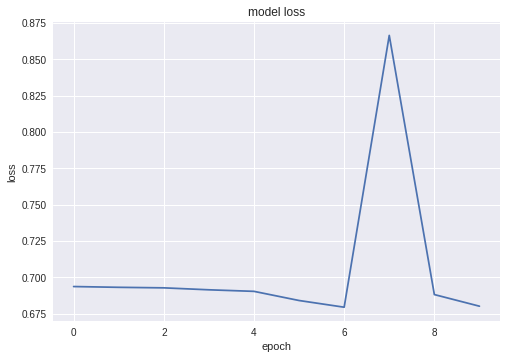

In [0]:
LSTM_model(1200)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 36s 2ms/step - loss: 0.6933 - acc: 0.5044 - val_loss: 0.6930 - val_acc: 0.5042
Epoch 2/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6926 - acc: 0.5014 - val_loss: 0.6929 - val_acc: 0.5002
Epoch 3/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6915 - acc: 0.5043 - val_loss: 0.6914 - val_acc: 0.5002
Epoch 4/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6866 - acc: 0.5084 - val_loss: 0.6892 - val_acc: 0.5000
Epoch 5/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6827 - acc: 0.5119 - val_loss: 0.6870 - val_acc: 0.5067
Epoch 6/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6812 - acc: 0.5113 - val_loss: 0.6882 - val_acc: 0.5044
Epoch 7/10
 1500/15600 [=>............................] - ETA: 25s - loss: 0.6764 - acc: 0.512715600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



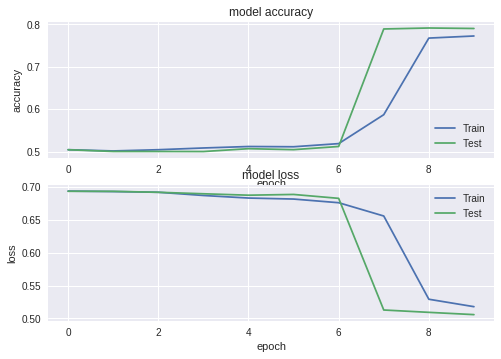

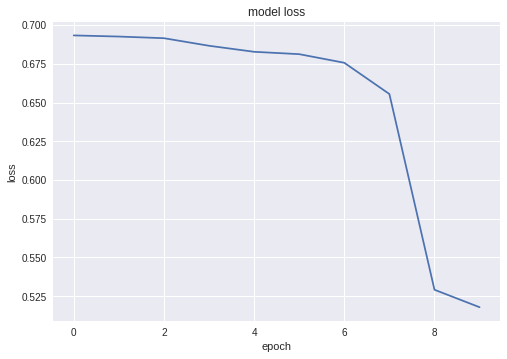

In [0]:
CNN_LSTM_model(1200)

In [26]:
LSTM_model_k(1200)

Epoch 1/10
16639/16639 [==============================] - 180s 11ms/step - loss: 0.6934 - acc: 0.5035
Epoch 2/10
16639/16639 [==============================] - 175s 11ms/step - loss: 0.6932 - acc: 0.5019
Epoch 3/10
16639/16639 [==============================] - 175s 10ms/step - loss: 0.6926 - acc: 0.5101
Epoch 4/10
16639/16639 [==============================] - 174s 10ms/step - loss: 0.6919 - acc: 0.5139
Epoch 5/10
16639/16639 [==============================] - 175s 11ms/step - loss: 0.6886 - acc: 0.5105
Epoch 6/10
16639/16639 [==============================] - 175s 10ms/step - loss: 0.6848 - acc: 0.5108
Epoch 7/10
16639/16639 [==============================] - 176s 11ms/step - loss: 0.6796 - acc: 0.5135
Epoch 8/10
  500/16639 [..............................] - ETA: 2:47 - loss: 0.6751 - acc: 0.538016639/16639 [==============================] - 174s 10ms/step - loss: 0.6768 - acc: 0.5214
Epoch 9/10
16639/16639 [==============================] - 175s 11ms/step - loss: 0.6759 - acc: 0.51

In [27]:
CNN_LSTM_model_k(1200)

Epoch 1/10
16639/16639 [==============================] - 40s 2ms/step - loss: 0.6936 - acc: 0.5015
Epoch 2/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6928 - acc: 0.5005
Epoch 3/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6928 - acc: 0.4937
Epoch 4/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6903 - acc: 0.5043
Epoch 5/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6857 - acc: 0.5069
Epoch 6/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6804 - acc: 0.5171
Epoch 7/10
16639/16639 [==============================] - 35s 2ms/step - loss: 0.6757 - acc: 0.5144
Epoch 8/10
 1500/16639 [=>............................] - ETA: 30s - loss: 0.6733 - acc: 0.526716639/16639 [==============================] - 35s 2ms/step - loss: 0.6087 - acc: 0.6494
Epoch 9/10
16639/16639 [==============================] - 35s 2ms/step - loss: 0.5492 - acc: 0.7544
Epoch 10/10
1663

### With Padding 0 - Length 800 words (90% documents < 800 words)

In [13]:
#maxlength = 800 (90% documents < 800 words)
sequences, vocabulary_size = create_sequence(800)
X = pad_sequences(sequences, maxlen=800, padding='post', truncating='post')

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 81s 5ms/step - loss: 0.6933 - acc: 0.5063 - val_loss: 0.6938 - val_acc: 0.4958
Epoch 2/10
15600/15600 [==============================] - 76s 5ms/step - loss: 0.6930 - acc: 0.5151 - val_loss: 0.6928 - val_acc: 0.5012
Epoch 3/10
15600/15600 [==============================] - 76s 5ms/step - loss: 0.6909 - acc: 0.5319 - val_loss: 0.6919 - val_acc: 0.5062
Epoch 4/10
15600/15600 [==============================] - 76s 5ms/step - loss: 0.6837 - acc: 0.5337 - val_loss: 0.6840 - val_acc: 0.5273
Epoch 5/10
15600/15600 [==============================] - 76s 5ms/step - loss: 0.6688 - acc: 0.5361 - val_loss: 0.6851 - val_acc: 0.5054
Epoch 6/10
15600/15600 [==============================] - 76s 5ms/step - loss: 0.6552 - acc: 0.5352 - val_loss: 0.6783 - val_acc: 0.5123
Epoch 7/10
 1500/15600 [=>............................] - ETA: 1:02 - loss: 0.6460 - acc: 0.550715600/15600 [====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



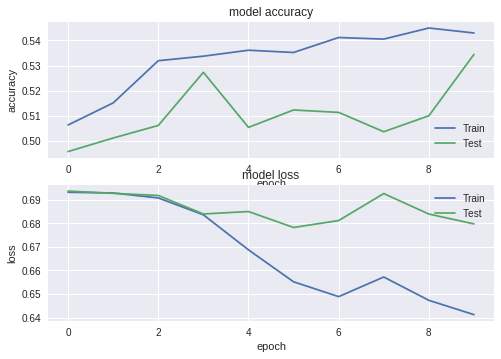

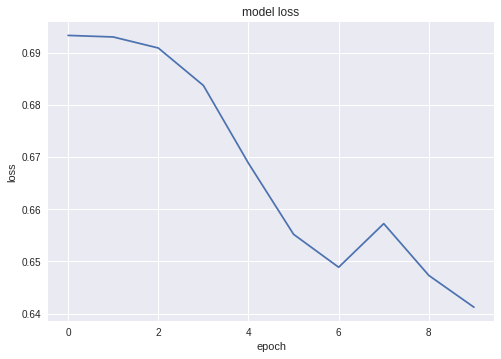

In [0]:
LSTM_model(800)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 27s 2ms/step - loss: 0.6934 - acc: 0.4990 - val_loss: 0.6928 - val_acc: 0.5156
Epoch 2/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.6909 - acc: 0.5190 - val_loss: 0.6564 - val_acc: 0.6563
Epoch 3/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.6424 - acc: 0.5886 - val_loss: 0.6218 - val_acc: 0.5967
Epoch 4/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.6556 - acc: 0.5488 - val_loss: 0.6303 - val_acc: 0.5815
Epoch 5/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.6575 - acc: 0.5443 - val_loss: 0.6392 - val_acc: 0.5329
Epoch 6/10
15600/15600 [==============================] - 21s 1ms/step - loss: 0.6509 - acc: 0.5510 - val_loss: 0.6351 - val_acc: 0.5442
Epoch 7/10
 1500/15600 [=>............................] - ETA: 17s - loss: 0.6400 - acc: 0.563315600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



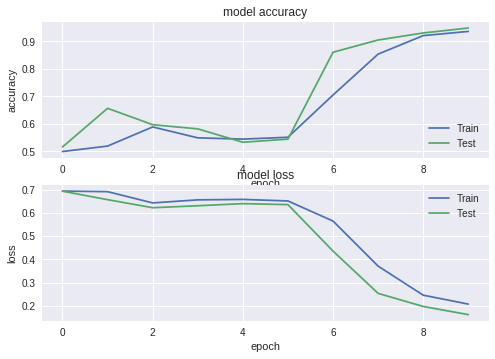

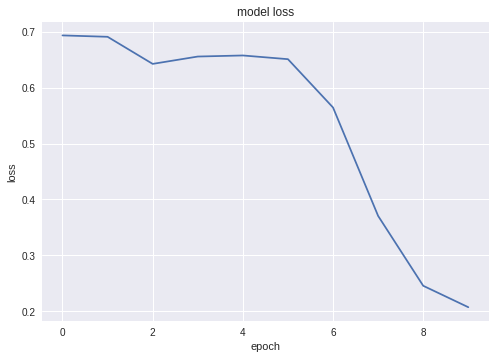

In [0]:
CNN_LSTM_model(800)

In [14]:
LSTM_model_k(800)

Epoch 1/10
16639/16639 [==============================] - 79s 5ms/step - loss: 0.6932 - acc: 0.5028
Epoch 2/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.6922 - acc: 0.5032
Epoch 3/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.6878 - acc: 0.5294
Epoch 4/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.6761 - acc: 0.5437
Epoch 5/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.6624 - acc: 0.5388
Epoch 6/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.6492 - acc: 0.5812
Epoch 7/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.5681 - acc: 0.7432
Epoch 8/10
 1500/16639 [=>............................] - ETA: 1:11 - loss: 0.5724 - acc: 0.732016639/16639 [==============================] - 80s 5ms/step - loss: 0.5522 - acc: 0.7431
Epoch 9/10
16639/16639 [==============================] - 80s 5ms/step - loss: 0.5363 - acc: 0.7487
Epoch 10/10
166

In [15]:
CNN_LSTM_model_k(800)

Epoch 1/10
16639/16639 [==============================] - 25s 2ms/step - loss: 0.6934 - acc: 0.4985
Epoch 2/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.6854 - acc: 0.5658
Epoch 3/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.6130 - acc: 0.7165
Epoch 4/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.5079 - acc: 0.8069
Epoch 5/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.4745 - acc: 0.8038
Epoch 6/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.4885 - acc: 0.7812
Epoch 7/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.4916 - acc: 0.7769
Epoch 8/10
 1500/16639 [=>............................] - ETA: 20s - loss: 0.4792 - acc: 0.781316639/16639 [==============================] - 23s 1ms/step - loss: 0.4980 - acc: 0.7737
Epoch 9/10
16639/16639 [==============================] - 23s 1ms/step - loss: 0.5007 - acc: 0.7662
Epoch 10/10
1663

### With Padding 0 - Length 400 words (60% documents < 400 words)

In [14]:
#maxlength = 400 (60% documents < 400 words)
sequences, vocabulary_size = create_sequence(400)
X = pad_sequences(sequences, maxlen=400, padding='post', truncating='post')

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 44s 3ms/step - loss: 0.6756 - acc: 0.5875 - val_loss: 0.6516 - val_acc: 0.6290
Epoch 2/10
15600/15600 [==============================] - 39s 2ms/step - loss: 0.6368 - acc: 0.6219 - val_loss: 0.5985 - val_acc: 0.6535
Epoch 3/10
15600/15600 [==============================] - 39s 2ms/step - loss: 0.5474 - acc: 0.7258 - val_loss: 0.4449 - val_acc: 0.8502
Epoch 4/10
15600/15600 [==============================] - 39s 2ms/step - loss: 0.4552 - acc: 0.8192 - val_loss: 0.4568 - val_acc: 0.8129
Epoch 5/10
15600/15600 [==============================] - 39s 2ms/step - loss: 0.4157 - acc: 0.8276 - val_loss: 0.4100 - val_acc: 0.8123
Epoch 6/10
15600/15600 [==============================] - 39s 2ms/step - loss: 0.4035 - acc: 0.8112 - val_loss: 0.4077 - val_acc: 0.8219
Epoch 7/10
 1500/15600 [=>............................] - ETA: 31s - loss: 0.4093 - acc: 0.814015600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



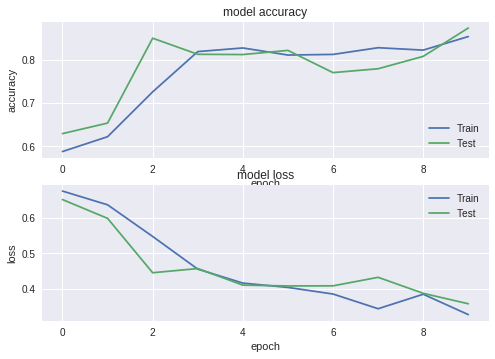

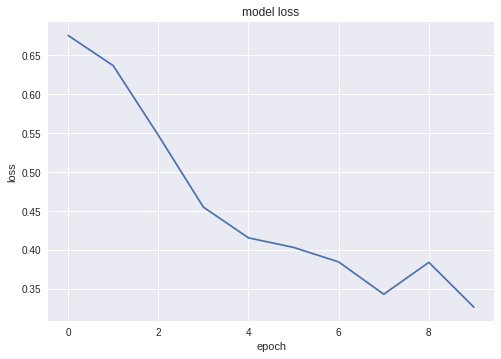

In [0]:
LSTM_model(400)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 17s 1ms/step - loss: 0.6671 - acc: 0.6147 - val_loss: 0.6240 - val_acc: 0.6448
Epoch 2/10
15600/15600 [==============================] - 11s 685us/step - loss: 0.5027 - acc: 0.7580 - val_loss: 0.3454 - val_acc: 0.8888
Epoch 3/10
15600/15600 [==============================] - 11s 686us/step - loss: 0.4600 - acc: 0.8170 - val_loss: 0.5167 - val_acc: 0.7885
Epoch 4/10
15600/15600 [==============================] - 11s 690us/step - loss: 0.5955 - acc: 0.7419 - val_loss: 0.6192 - val_acc: 0.5162
Epoch 5/10
15600/15600 [==============================] - 11s 685us/step - loss: 0.5906 - acc: 0.6204 - val_loss: 0.5640 - val_acc: 0.6754
Epoch 6/10
15600/15600 [==============================] - 11s 690us/step - loss: 0.5261 - acc: 0.6686 - val_loss: 0.4360 - val_acc: 0.7833
Epoch 7/10
 1000/15600 [>.............................] - ETA: 9s - loss: 0.4459 - acc: 0.763015600/15600 [============

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



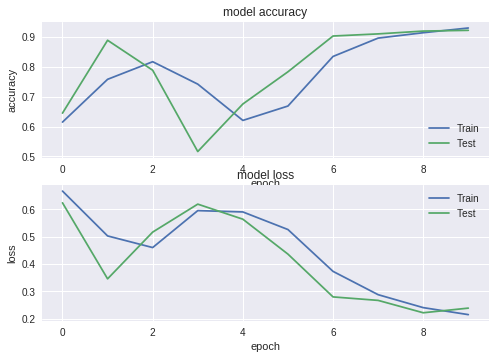

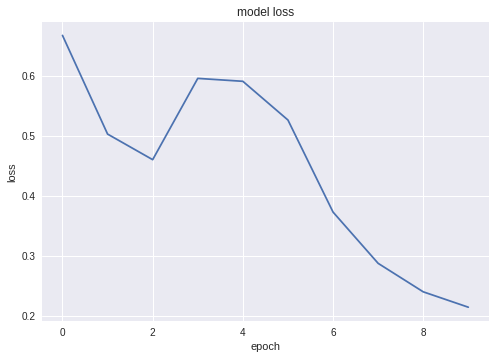

In [0]:
CNN_LSTM_model(400)

In [17]:
LSTM_model_k(400)

Epoch 1/10
16639/16639 [==============================] - 45s 3ms/step - loss: 0.6694 - acc: 0.6141
Epoch 2/10
16639/16639 [==============================] - 42s 3ms/step - loss: 0.6337 - acc: 0.6314
Epoch 3/10
16639/16639 [==============================] - 43s 3ms/step - loss: 0.5521 - acc: 0.7155
Epoch 4/10
16639/16639 [==============================] - 43s 3ms/step - loss: 0.5278 - acc: 0.7359
Epoch 5/10
16639/16639 [==============================] - 43s 3ms/step - loss: 0.4695 - acc: 0.7833
Epoch 6/10
16639/16639 [==============================] - 43s 3ms/step - loss: 0.4182 - acc: 0.8032
Epoch 7/10
16639/16639 [==============================] - 43s 3ms/step - loss: 0.3758 - acc: 0.8046
Epoch 8/10
 1500/16639 [=>............................] - ETA: 37s - loss: 0.3421 - acc: 0.845316639/16639 [==============================] - 43s 3ms/step - loss: 0.3763 - acc: 0.8330
Epoch 9/10
16639/16639 [==============================] - 42s 3ms/step - loss: 0.3395 - acc: 0.8365
Epoch 10/10
1663

In [15]:
CNN_LSTM_model_k(400)

Epoch 1/10
16639/16639 [==============================] - 13s 761us/step - loss: 0.6624 - acc: 0.5992
Epoch 2/10
16639/16639 [==============================] - 11s 659us/step - loss: 0.4572 - acc: 0.8000
Epoch 3/10
16639/16639 [==============================] - 11s 666us/step - loss: 0.4112 - acc: 0.8347
Epoch 4/10
16639/16639 [==============================] - 11s 666us/step - loss: 0.4897 - acc: 0.7173
Epoch 5/10
16639/16639 [==============================] - 11s 663us/step - loss: 0.4160 - acc: 0.7639
Epoch 6/10
16639/16639 [==============================] - 11s 664us/step - loss: 0.3877 - acc: 0.8319
Epoch 7/10
16639/16639 [==============================] - 11s 668us/step - loss: 0.3462 - acc: 0.8183
Epoch 8/10
 1000/16639 [>.............................] - ETA: 10s - loss: 0.3163 - acc: 0.887016639/16639 [==============================] - 11s 663us/step - loss: 0.3043 - acc: 0.8761
Epoch 9/10
16639/16639 [==============================] - 11s 661us/step - loss: 0.2467 - acc: 0.913

### With Padding 0 - Length 297 words (50% documents < 297 words)

In [20]:
#maxlength = 297 (50% documents < 297 words)
sequences, vocabulary_size = create_sequence(297)
X = pad_sequences(sequences, maxlen=297, padding='post', truncating='post')

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 31s 2ms/step - loss: 0.6655 - acc: 0.6208 - val_loss: 0.6391 - val_acc: 0.6415
Epoch 2/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.5963 - acc: 0.6754 - val_loss: 0.6606 - val_acc: 0.8275
Epoch 3/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.4254 - acc: 0.8367 - val_loss: 0.4502 - val_acc: 0.7981
Epoch 4/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.4129 - acc: 0.7963 - val_loss: 0.4160 - val_acc: 0.7610
Epoch 5/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3626 - acc: 0.8035 - val_loss: 0.3463 - val_acc: 0.8825
Epoch 6/10
15600/15600 [==============================] - 28s 2ms/step - loss: 0.3407 - acc: 0.8404 - val_loss: 0.3194 - val_acc: 0.8775
Epoch 7/10
 1500/15600 [=>............................] - ETA: 23s - loss: 0.3248 - acc: 0.856015600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



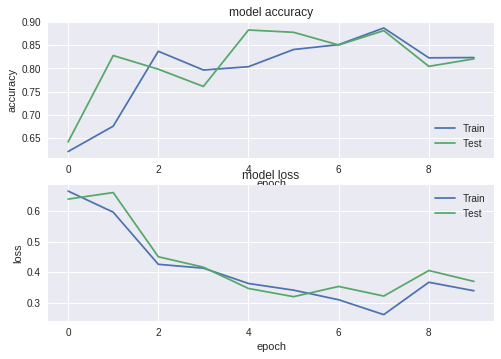

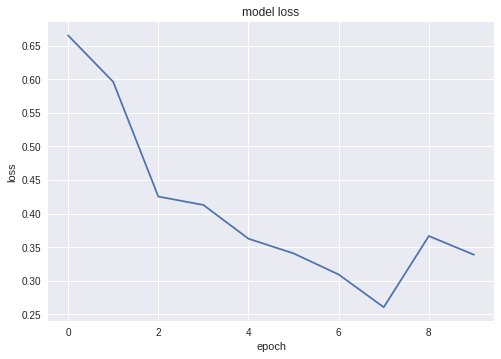

In [0]:
LSTM_model(297)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 10s 669us/step - loss: 0.6548 - acc: 0.6178 - val_loss: 0.5841 - val_acc: 0.6723
Epoch 2/10
15600/15600 [==============================] - 8s 504us/step - loss: 0.4258 - acc: 0.8261 - val_loss: 0.4870 - val_acc: 0.7492
Epoch 3/10
15600/15600 [==============================] - 8s 510us/step - loss: 0.4201 - acc: 0.8096 - val_loss: 0.3171 - val_acc: 0.8940
Epoch 4/10
15600/15600 [==============================] - 8s 510us/step - loss: 0.3398 - acc: 0.8915 - val_loss: 0.4020 - val_acc: 0.8519
Epoch 5/10
15600/15600 [==============================] - 8s 508us/step - loss: 0.4058 - acc: 0.8284 - val_loss: 0.3694 - val_acc: 0.8575
Epoch 6/10
15600/15600 [==============================] - 8s 504us/step - loss: 0.2944 - acc: 0.9062 - val_loss: 0.2683 - val_acc: 0.9200
Epoch 7/10
 1000/15600 [>.............................] - ETA: 6s - loss: 0.2608 - acc: 0.919015600/15600 [===============

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



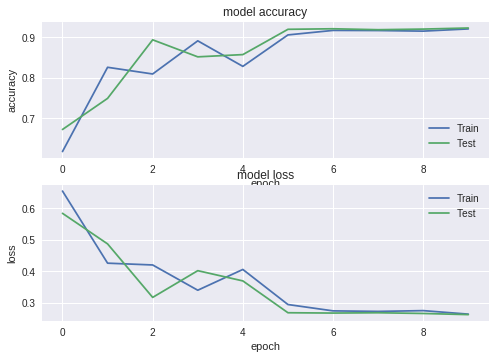

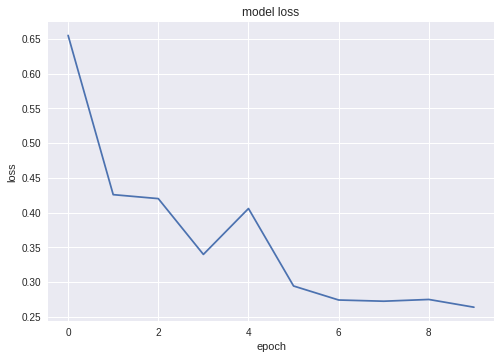

In [0]:
CNN_LSTM_model(297)

In [21]:
LSTM_model_k(297)

Epoch 1/10
16639/16639 [==============================] - 34s 2ms/step - loss: 0.6614 - acc: 0.6292
Epoch 2/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.5984 - acc: 0.6699
Epoch 3/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.4349 - acc: 0.8259
Epoch 4/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.3881 - acc: 0.8487
Epoch 5/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.3556 - acc: 0.8471
Epoch 6/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.3180 - acc: 0.8655
Epoch 7/10
16639/16639 [==============================] - 30s 2ms/step - loss: 0.2977 - acc: 0.8680
Epoch 8/10
 1500/16639 [=>............................] - ETA: 27s - loss: 0.2845 - acc: 0.872716639/16639 [==============================] - 30s 2ms/step - loss: 0.3233 - acc: 0.8649
Epoch 9/10
16639/16639 [==============================] - 31s 2ms/step - loss: 0.3127 - acc: 0.8745
Epoch 10/10
1663

In [22]:
CNN_LSTM_model_k(297)

Epoch 1/10
16639/16639 [==============================] - 13s 771us/step - loss: 0.6462 - acc: 0.6354
Epoch 2/10
16639/16639 [==============================] - 8s 510us/step - loss: 0.3993 - acc: 0.8619
Epoch 3/10
16639/16639 [==============================] - 9s 513us/step - loss: 0.3338 - acc: 0.8797
Epoch 4/10
16639/16639 [==============================] - 9s 513us/step - loss: 0.2878 - acc: 0.9118
Epoch 5/10
16639/16639 [==============================] - 9s 516us/step - loss: 0.3728 - acc: 0.8869
Epoch 6/10
16639/16639 [==============================] - 9s 511us/step - loss: 0.3816 - acc: 0.8249
Epoch 7/10
16639/16639 [==============================] - 9s 514us/step - loss: 0.3716 - acc: 0.8098
Epoch 8/10
 1000/16639 [>.............................] - ETA: 7s - loss: 0.3094 - acc: 0.878016639/16639 [==============================] - 9s 519us/step - loss: 0.2744 - acc: 0.8864
Epoch 9/10
16639/16639 [==============================] - 8s 510us/step - loss: 0.2257 - acc: 0.9287
Epoch 1

### With Padding 0 - Length 200 words (35% documents < 200 words)

In [17]:
#maxlength = 200 (50% documents < 200 words)
sequences, vocabulary_size = create_sequence(200)
X = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

#labels (y)
Y = np.array(data['label'].values) 

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 22s 1ms/step - loss: 0.6565 - acc: 0.6211 - val_loss: 0.6169 - val_acc: 0.6450
Epoch 2/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.5193 - acc: 0.7646 - val_loss: 0.3921 - val_acc: 0.8663
Epoch 3/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3538 - acc: 0.8814 - val_loss: 0.3607 - val_acc: 0.8698
Epoch 4/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3294 - acc: 0.8844 - val_loss: 0.3291 - val_acc: 0.8829
Epoch 5/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.3066 - acc: 0.8890 - val_loss: 0.3195 - val_acc: 0.8790
Epoch 6/10
15600/15600 [==============================] - 19s 1ms/step - loss: 0.2726 - acc: 0.8956 - val_loss: 0.3011 - val_acc: 0.8688
Epoch 7/10
 1500/15600 [=>............................] - ETA: 16s - loss: 0.2609 - acc: 0.890015600/15600 [=====================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



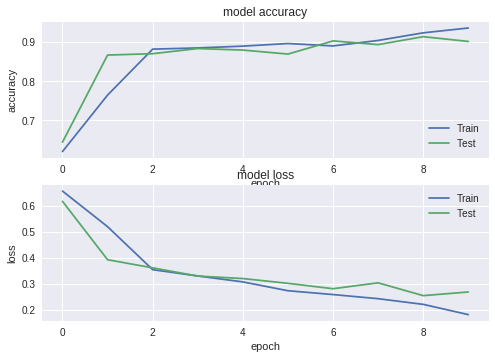

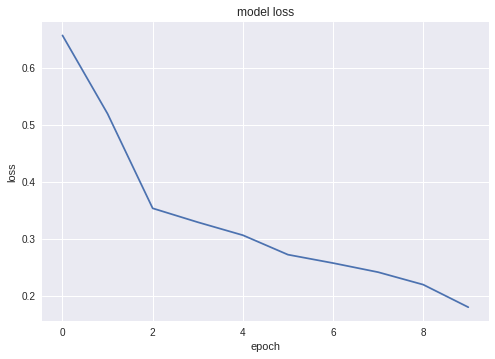

In [0]:
LSTM_model(200)

Train on 15600 samples, validate on 5200 samples
Epoch 1/10
15600/15600 [==============================] - 9s 572us/step - loss: 0.6024 - acc: 0.6754 - val_loss: 0.3340 - val_acc: 0.8792
Epoch 2/10
15600/15600 [==============================] - 5s 346us/step - loss: 0.2914 - acc: 0.9035 - val_loss: 0.1961 - val_acc: 0.9377
Epoch 3/10
15600/15600 [==============================] - 5s 349us/step - loss: 0.1665 - acc: 0.9516 - val_loss: 0.1409 - val_acc: 0.9569
Epoch 4/10
15600/15600 [==============================] - 5s 348us/step - loss: 0.1176 - acc: 0.9683 - val_loss: 0.1199 - val_acc: 0.9635
Epoch 5/10
15600/15600 [==============================] - 5s 347us/step - loss: 0.0835 - acc: 0.9776 - val_loss: 0.1151 - val_acc: 0.9660
Epoch 6/10
15600/15600 [==============================] - 5s 343us/step - loss: 0.0596 - acc: 0.9855 - val_loss: 0.1258 - val_acc: 0.9710
Epoch 7/10
 3000/15600 [====>.........................] - ETA: 3s - loss: 0.0397 - acc: 0.991715600/15600 [================

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



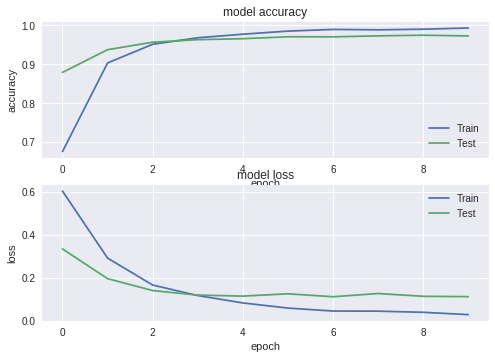

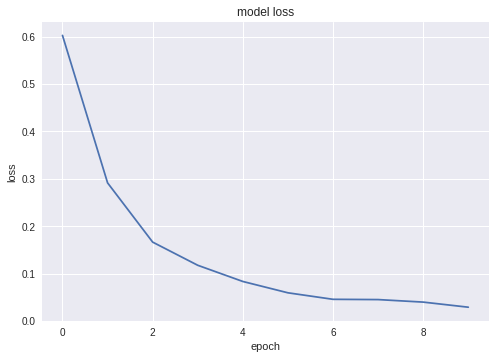

In [0]:
CNN_LSTM_model(200)

In [18]:
LSTM_model_k(200)

Epoch 1/10
16639/16639 [==============================] - 22s 1ms/step - loss: 0.6526 - acc: 0.6150
Epoch 2/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.4734 - acc: 0.8060
Epoch 3/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.3887 - acc: 0.8476
Epoch 4/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.3482 - acc: 0.8642
Epoch 5/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.3024 - acc: 0.8859
Epoch 6/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.2673 - acc: 0.8912
Epoch 7/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.2467 - acc: 0.8976
Epoch 8/10
 1500/16639 [=>............................] - ETA: 18s - loss: 0.2001 - acc: 0.922716639/16639 [==============================] - 21s 1ms/step - loss: 0.2181 - acc: 0.9122
Epoch 9/10
16639/16639 [==============================] - 21s 1ms/step - loss: 0.2332 - acc: 0.9187
Epoch 10/10
1663

In [19]:
CNN_LSTM_model_k(200)

Epoch 1/10
16639/16639 [==============================] - 9s 520us/step - loss: 0.6034 - acc: 0.6741
Epoch 2/10
16639/16639 [==============================] - 6s 350us/step - loss: 0.2726 - acc: 0.9129
Epoch 3/10
16639/16639 [==============================] - 6s 352us/step - loss: 0.1634 - acc: 0.9554
Epoch 4/10
16639/16639 [==============================] - 6s 348us/step - loss: 0.1507 - acc: 0.9651
Epoch 5/10
16639/16639 [==============================] - 6s 353us/step - loss: 0.3091 - acc: 0.9016
Epoch 6/10
16639/16639 [==============================] - 6s 354us/step - loss: 0.4011 - acc: 0.8103
Epoch 7/10
16639/16639 [==============================] - 6s 351us/step - loss: 0.3743 - acc: 0.8253
Epoch 8/10
 1500/16639 [=>............................] - ETA: 5s - loss: 0.3449 - acc: 0.840016639/16639 [==============================] - 6s 352us/step - loss: 0.3447 - acc: 0.8278
Epoch 9/10
16639/16639 [==============================] - 6s 352us/step - loss: 0.2347 - acc: 0.9115
Epoch 10